# Importing Data and Libraries

In [2]:
import os 
import time 
import numpy as np
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Callable, Optional, Type, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
import torchvision.models as models

from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision import datasets

In [4]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Ensure all images are 32x32
    transforms.ToTensor(),
])

# Download and create the CIFAR-10 train and test datasets
train_ds = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_ds = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

print(f'Train Samples: {len(train_ds)} || Test Samples: {len(test_ds)} || Classes: {len(train_ds.classes)}')

100%|██████████| 170498071/170498071 [00:02<00:00, 73418570.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Samples: 50000 || Test Samples: 10000 || Classes: 10


# Building the Model

In [5]:
class MHSA(nn.Module):

    def __init__(
            self,
            dim: int,
            num_heads: int = 8
            ):
        
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q = nn.Linear(dim, dim)
        self.k = nn.Linear(dim, dim)
        self.v = nn.Linear(dim, dim)

        self.proj = nn.Linear(dim, dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, P, C = x.shape
        H = self.num_heads
        q = self.q(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        k = self.k(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        v = self.v(x).view(B, P, H, -1).transpose(1, 2) # (B, H, P, head_size)
        
        q = q * self.scale

        attn = q @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B, P, C)
        x = self.proj(x)

        return x

class PatchEmbed(nn.Module):
    def __init__(self,
                 img_size: int,
                 patch_size: int,
                 in_chans: int,
                 embed_dim: int,
                ):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size

        self.grid_size = (self.img_size // self.patch_size, ) * 2
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_chans, 
                              embed_dim, 
                              kernel_size=patch_size, 
                              stride=patch_size, 
                              padding=0)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2) 
        return x
    

class PositionalEmbedding(nn.Module):
    def __init__(self, num_patches: int, embed_dim: int):
        super().__init__()
        self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches, embed_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.position_embeddings


class Attention(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int, embed_dim: int, num_heads: int):
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        self.positional_embedding = PositionalEmbedding(self.patch_embed.num_patches, embed_dim)
        self.mhsa_layer = MHSA(embed_dim, num_heads)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.patch_embed(x)  # Shape: (B, num_patches, embed_dim)
        x = self.positional_embedding(x)
        x = self.mhsa_layer(x)  # Shape: (B, num_patches, embed_dim)

        return x

In [6]:
class AttnModel(nn.Module):
    def __init__(self, img_size: int, patch_size: int, in_channels: int, embed_dim: int, num_heads: int, classes:int =10):
        super().__init__()
        
        self.attn = Attention(img_size=img_size, patch_size=patch_size, in_channels=in_channels, embed_dim=embed_dim, num_heads=num_heads)

        num_patches = (img_size // patch_size) ** 2
        self.fc = nn.Linear(num_patches*embed_dim, classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.attn(x)
        B, P, C = x.shape
        
        x = x.view(B, -1)
        x = self.fc(x)
        
        return x

# Training the Model

In [7]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_step(model, dataloader, criterion, optimizer, device):
    '''Train for one epoch'''
    
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for i, data in enumerate(dataloader):
       
        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.argmax(logits.detach(), dim=1)
        train_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rTraining: [{i+1}/{len(dataloader)}] '
              f'Loss: {train_loss / (i + 1):.4f} '
              f'Acc: {train_acc / (i + 1):.4f}', end='')

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return train_loss, train_acc

@torch.inference_mode()
def eval_step(model, dataloader, criterion, device):
    '''Evaluate the model'''
    
    model.eval()

    eval_loss = 0.0
    eval_acc = 0.0

    for i, data in enumerate(dataloader):

        X, y = data[0].to(device), data[1].to(device)
        
        logits = model(X)
        loss = criterion(logits, y)
        eval_loss += loss.item()

        y_pred = torch.argmax(logits.detach(), dim=1)
        eval_acc += (y_pred == y).sum().item() / len(y)

        # Print dynamic progress on the same line using \r
        print(f'\rEvaluation: [{i+1}/{len(dataloader)}] '
              f'Loss: {eval_loss / (i + 1):.4f} '
              f'Acc: {eval_acc / (i + 1):.4f}', end='')

    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    # Move to the next line after the loop is done
    print()  
    
    return eval_loss, eval_acc

In [10]:
import torch.optim as optim
import csv
from tqdm import tqdm 
import time as time

torch.manual_seed(42)

model = AttnModel(img_size=32, patch_size=8, in_channels=3, embed_dim=784, num_heads=16, classes=10)

out_dir = './attn-output'
os.makedirs(out_dir, exist_ok=True)
epochs = 10
lr = 3e-4
batch_size = 32

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

bar_format = '{l_bar}{bar} | Epoch: {n_fmt}/{total_fmt} | Time: {elapsed} < {remaining} | {rate_fmt}'
model.to(device)

params = count_trainable_params(model)
print(f'Finetuning {params*1e-6:.3f}M params on {device} for {epochs} epochs ...\n')

csv_file = os.path.join(out_dir, 'log.csv')
model_file = os.path.join(out_dir, 'weights.pth')

with open(csv_file, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc'])

    for epoch in tqdm(range(epochs), desc="Epochs", bar_format=bar_format, leave=True):
        start_time = time.time()  

        train_loss, train_acc = train_step(model, train_dl, criterion, optimizer, device)
        val_loss, val_acc = eval_step(model, test_dl, criterion, device)
        
        writer.writerow([epoch+1, train_loss, train_acc, val_loss, val_acc])
        
        epoch_duration = time.time() - start_time

        tqdm.write(f"============ Epoch {epoch + 1} --> Train Acc: {train_acc:.4f} || Val Acc: {val_acc:.4f} || Time: {epoch_duration:.2f} s ============\n")
    
    torch.save(model.state_dict(), model_file)

Finetuning 2.751M params on cuda for 10 epochs ...



Epochs:   0%|           | Epoch: 0/10 | Time: 00:00 < ? | ?it/s

Training: [1563/1563] Loss: 1.7460 Acc: 0.3670
Evaluation: [292/313] Loss: 1.5564 Acc: 0.4408

Epochs:  10%|█          | Epoch: 1/10 | Time: 00:11 < 01:45 | 11.73s/it

Evaluation: [313/313] Loss: 1.5554 Acc: 0.4402
============ Epoch 1 --> Train Acc: 0.3670 || Val Acc: 0.4402 || Time: 11.73 s ============

Training: [1563/1563] Loss: 1.5193 Acc: 0.4581
Evaluation: [302/313] Loss: 1.4466 Acc: 0.4903

Epochs:  20%|██         | Epoch: 2/10 | Time: 00:23 < 01:32 | 11.54s/it

Evaluation: [313/313] Loss: 1.4477 Acc: 0.4875
============ Epoch 2 --> Train Acc: 0.4581 || Val Acc: 0.4875 || Time: 11.40 s ============

Training: [1563/1563] Loss: 1.3991 Acc: 0.5046
Evaluation: [313/313] Loss: 1.3853 Acc: 0.5113

Epochs:  30%|███        | Epoch: 3/10 | Time: 00:34 < 01:20 | 11.49s/it


============ Epoch 3 --> Train Acc: 0.5046 || Val Acc: 0.5113 || Time: 11.43 s ============

Training: [1563/1563] Loss: 1.3104 Acc: 0.5345
Evaluation: [303/313] Loss: 1.3581 Acc: 0.5191

Epochs:  40%|████       | Epoch: 4/10 | Time: 00:46 < 01:10 | 11.67s/it

Evaluation: [313/313] Loss: 1.3634 Acc: 0.5169
============ Epoch 4 --> Train Acc: 0.5345 || Val Acc: 0.5169 || Time: 11.95 s ============

Training: [1563/1563] Loss: 1.2495 Acc: 0.5595
Evaluation: [313/313] Loss: 1.3569 Acc: 0.5173

Epochs:  50%|█████      | Epoch: 5/10 | Time: 00:57 < 00:57 | 11.59s/it


============ Epoch 5 --> Train Acc: 0.5595 || Val Acc: 0.5173 || Time: 11.44 s ============

Training: [1563/1563] Loss: 1.1943 Acc: 0.5777
Evaluation: [299/313] Loss: 1.2846 Acc: 0.5508

Epochs:  60%|██████     | Epoch: 6/10 | Time: 01:09 < 00:46 | 11.66s/it

Evaluation: [313/313] Loss: 1.2872 Acc: 0.5483
============ Epoch 6 --> Train Acc: 0.5777 || Val Acc: 0.5483 || Time: 11.81 s ============

Training: [1563/1563] Loss: 1.1430 Acc: 0.5968
Evaluation: [310/313] Loss: 1.3245 Acc: 0.5348

Epochs:  70%|███████    | Epoch: 7/10 | Time: 01:21 < 00:34 | 11.65s/it

Evaluation: [313/313] Loss: 1.3248 Acc: 0.5345
============ Epoch 7 --> Train Acc: 0.5968 || Val Acc: 0.5345 || Time: 11.63 s ============

Training: [1563/1563] Loss: 1.0920 Acc: 0.6144
Evaluation: [309/313] Loss: 1.3714 Acc: 0.5356

Epochs:  80%|████████   | Epoch: 8/10 | Time: 01:32 < 00:23 | 11.57s/it

Evaluation: [313/313] Loss: 1.3699 Acc: 0.5354
============ Epoch 8 --> Train Acc: 0.6144 || Val Acc: 0.5354 || Time: 11.39 s ============

Training: [1563/1563] Loss: 1.0506 Acc: 0.6302
Evaluation: [304/313] Loss: 1.3560 Acc: 0.5461

Epochs:  90%|█████████  | Epoch: 9/10 | Time: 01:44 < 00:11 | 11.64s/it

Evaluation: [313/313] Loss: 1.3611 Acc: 0.5440
============ Epoch 9 --> Train Acc: 0.6302 || Val Acc: 0.5440 || Time: 11.80 s ============

Training: [1563/1563] Loss: 1.0064 Acc: 0.6439
Evaluation: [313/313] Loss: 1.3563 Acc: 0.5506

Epochs: 100%|██████████ | Epoch: 10/10 | Time: 01:56 < 00:00 | 11.61s/it


============ Epoch 10 --> Train Acc: 0.6439 || Val Acc: 0.5506 || Time: 11.45 s ============



# Visulasing the Attention Map

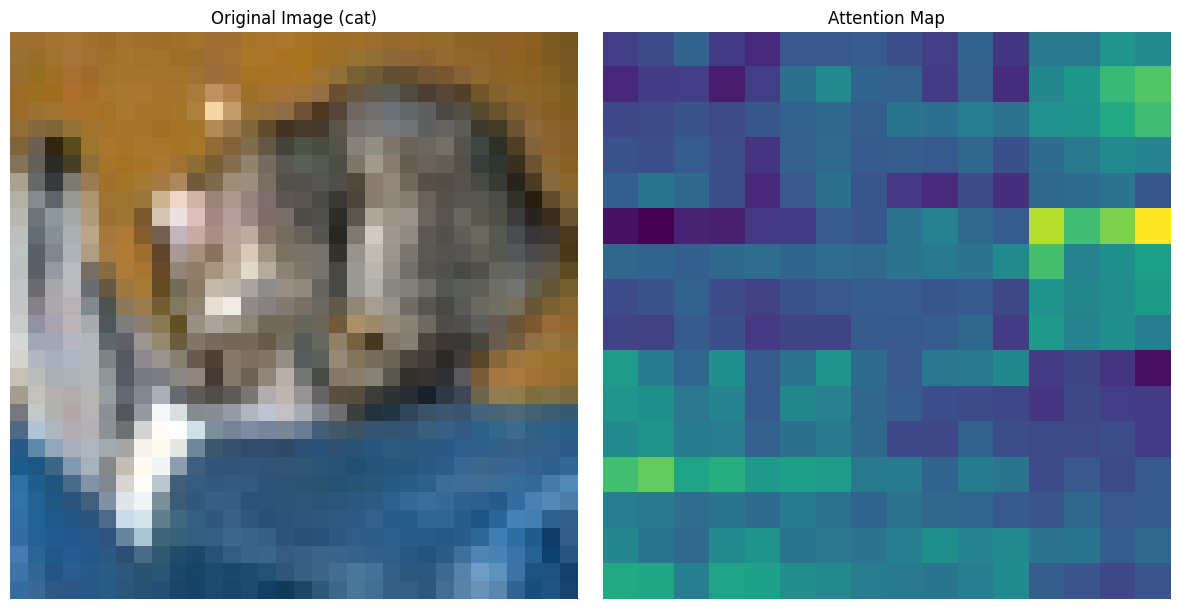

In [17]:
torch.manual_seed(42)

images, labels = next(iter(test_dl))  
classes = test_ds.classes

img, label = images[0].unsqueeze(0).to(device), classes[labels[0].item()]  

plt.figure(figsize=(12, 6))

patches = model.attn.patch_embed(img)
patches = model.attn.positional_embedding(patches)

q_weights = model.attn.mhsa_layer.q.weight.data
k_weights = model.attn.mhsa_layer.k.weight.data

queries = patches @ q_weights  # Shape: (B, num_patches, embed_dim)
keys = patches @ k_weights.T   # Shape: (B, num_patches, embed_dim)

# Reshape and transpose queries and keys to (B, H, P, head_dim)
B, P, _ = queries.shape
H = model.attn.mhsa_layer.num_heads
head_dim = queries.shape[-1] // H

queries = queries.view(B, P, H, head_dim).transpose(1, 2)
keys = keys.view(B, P, H, head_dim).transpose(1, 2)
attn_scores = ((queries @ keys.transpose(-2, -1)) * (head_dim ** -0.5)).view(B, H, -1)  # Shape: (B, H, P*P)

# Compute attention map using softmax and averaging over heads
attn_map = attn_scores.softmax(dim=-1)
attn_map = attn_map.view(B, H, P, P)
attn_map = torch.mean(attn_map, dim=1)  # Shape: (B, P, P)

attention_map = attn_map.squeeze(0).detach().cpu().numpy()  # Shape: (P, P)

img_np = img[0].permute(1, 2, 0).cpu().numpy()

plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f'Original Image ({label})')  # Include label in the title
plt.axis('off')  # Hide axes

# Plot the attention map
plt.subplot(1, 2, 2)
plt.imshow(attention_map, cmap='viridis')
plt.title(f'Attention Map')
plt.axis('off')  # Hide axes

plt.tight_layout()
plt.savefig('./task6_2.png')
plt.show()